In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
import numba
from numba import jit, vectorize, cuda
from IPython.display import HTML

For a rough terrain,
$$
\nabla \cdot (T\,\nabla u) = \nabla \cdot \left(T\frac{\partial u}{\partial x} \hat{x} + T\frac{\partial u}{\partial y} \hat{y} \right)\\ = \frac{\partial}{\partial x}\left(T\frac{\partial u}{\partial x}\right)  + \frac{\partial}{\partial y}\left(T\frac{\partial u}{\partial y}\right)\\
= \frac{\partial T}{\partial x}\frac{\partial u}{\partial x} + T\frac{\partial^2 u}{\partial x^2} + \frac{\partial T}{\partial y}\frac{\partial u}{\partial y} + T\frac{\partial^2 u}{\partial y^2}\\
= T\,\nabla^2 u + \frac{\partial T}{\partial x}\frac{\partial u}{\partial x} + \frac{\partial T}{\partial y}\frac{\partial u}{\partial y}
$$

Now consider only the $x$ coordinate. We can approximate for a fixed $y$,
$$
\frac{\partial T}{\partial x}\frac{\partial u}{\partial x} \approx \frac{T(x-dx)[u(x-dx)-u(x)] + T(x+dx)[u(x+dx)-u(x)]}{2\,dx^2}\\
T\,\nabla^2 u \approx \frac{u(x-dx)-2u(x)+u(x+dx)}{2\,dx^2}T(x)
$$

Hence, the full diverge term becomes for a fixed $t$

$$
\nabla \cdot (T\,\nabla u)|_{(x,y)} = \frac{1}{2\,dx^2} \left\{ T(x,y) [u(x-dx,y)+u(x+dx,y)+u(x,y-dy)+u(x,y+dy)-4u(x,y)]  + \\ T(x-dx,y)[u(x-dx,y)-u(x,y)] + T(x+dx,y)[u(x+dx,y)-u(x,y)] +\\
T(x,y-dx)[u(x,y-dx)-u(x,y)]+T(x,y+dx)[u(x,y+dx)-u(x,y)]\right\}
$$

In a discrete space,

$$
\nabla \cdot (T\,\nabla u)|_{i,j} = \frac{1}{2\,\Delta x^2}  \Bigl\{ T_{i,j} [u_{i-1,j}+u_{i+1,j}+u_{i,j-1}+u_{i,j+1}-4u_{i,j}] \Bigl. \nonumber
\\ +T_{i-1,j}[u_{i-1,j}-u_{i,j}] + T_{i+1,j}[u_{i+1,j}-u_{i,j}] \nonumber\\ 
\Bigl. + T_{i,j-1}[u_{i,j-1}-u_{i,j}]+T_{i,j+1}[u_{i,j+1}-u_{i,j}]\Bigl\}\\
\text{thus, }u_{i,j}^{(t+1)} = u_{i,j}^{(t)} + \Delta t\left[(r-h)u_{i,j}^{(t)} - \frac{r(u_{i,j}^{(t)})^2}{K} + \nabla \cdot (T\,\nabla u)|_{i,j}^{(t)}\right]
$$

# Simulation

Initialise space grid with random spawns

In [3]:
n = 100
i = 5
coords = np.array([(np.random.randint(i, n-i), np.random.randint(i, n-i)) for _ in range (50)])
init_population = np.zeros((n, n))
for x, y in coords:
    init_population[x,y] = 2

[Text(1, 0.0, '0.0'), Text(1, 1.0, '1.0'), Text(1, 2.0, '2.0')]

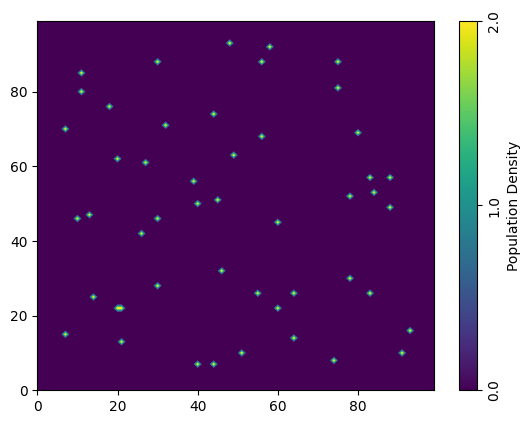

In [3]:
fig,ax = plt.subplots()
vmin,vmax = int(np.min(init_population)), int(np.max(init_population))
contourf_ = ax.contourf(init_population, levels=np.linspace(vmin,vmax,400))
cbar = fig.colorbar(contourf_,ticks=range(vmin, vmax))
cbar.ax.set_yticks(ticks=np.linspace(0,2,3))
cbar.ax.set_ylabel('Population Density')
cbar.ax.set_yticklabels(np.linspace(0,2,3), rotation='vertical', va='center')

In [4]:
def gauss2d(x, y, cx=0.5, cy=0.5):
    # gaussian in domain [0,1] x [0,1]
    z = np.exp(-(x-cx)**2-(y-cy)**2)
    return z

def gauss2d_inv(x, y, cx=0.5, cy=0.5):
    # inverted gaussian function
    z = 1-np.exp(-(x-cx)**2-(y-cy)**2)
    return z

def twohills(x, y):
    # a combination of two gaussian hills
    z = 1.04-np.exp((-(x-0.2)**2-(y-0.3)**2)/0.15)-np.exp((-(x-0.8)**2-(y-0.7)**2)/0.1)
    return z

def ridge(x,y):
    # a terrain function that looks like a ridge
    return np.sin((x+3)*(y-0.5)**2)

create rough terrain

C:\Users\beast\AppData\Local\Temp\ipykernel_29256\974144600.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(np.linspace(0,0.5,9), rotation='vertical', va='center')


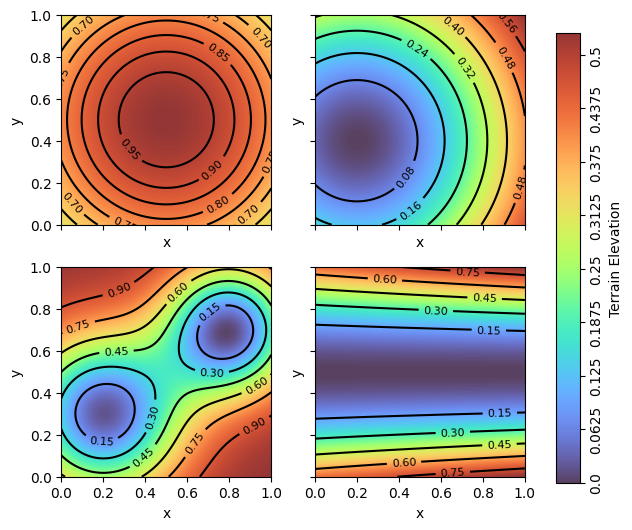

In [15]:
X    = np.linspace(0, 1, n)
Y    = np.linspace(0, 1, n)
X, Y = np.meshgrid(X, Y)

terrain1 = gauss2d(X,Y)
terrain2 = gauss2d_inv(X,Y, cx=0.2, cy=0.4)
terrain3 = twohills(X,Y)
terrain4 = ridge(X,Y)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharey=True, sharex=True)

terrains = [terrain1, terrain2, terrain3, terrain4]
for ax, terrain in zip(axes.flat, terrains):
    terrain_contour = ax.contour(X,Y,terrain,colors='black')
    ax.clabel(terrain_contour, inline=True, fontsize=8)
    color = ax.imshow(terrain, extent=[0, 1, 0, 1], origin='lower', cmap='turbo', alpha=0.8, vmin=0)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

cax = fig.add_axes([0.95, 0.1, 0.04, 0.75])
cbar = fig.colorbar(color, cax=cax, orientation='vertical')
cbar.ax.set_ylabel('Terrain Elevation')
cbar.ax.set_yticklabels(np.linspace(0,0.5,9), rotation='vertical', va='center')
plt.savefig(f'plots/5c/terrains.png', bbox_inches='tight', dpi=200)

Set the dimensions of the problem

In [6]:
x = 1
dx = 0.05
dt = 0.0001

In [7]:
total_time = 20 # sec
times = 36000*7#int(total_time/dt
times_snapshot = 3600
f = int(times/times_snapshot)
population_frames = np.zeros([times_snapshot, 100, 100])
population_frames[0] = init_population
population_size = np.zeros(times)

* Number of differential equation update iterations `times`
* Number of snapshots we will take `times_snaphot`. 
* The array of snapshots we will take of the turkey


In [8]:
print(f'Snapshot taken every {f}th frame.')
print(f'Total time of simulation is {times*dt} sec.')
print(f'Snapshot taken every {f*dt} sec.')

Snapshot taken every 70th frame.
Total time of simulation is 25.200000000000003 sec.
Snapshot taken every 0.007 sec.


Compute $s = \alpha \Delta t / \Delta x^2$. $s$ needs to be much less than 1/4 for this to work.

In [14]:
np.max(terrain4 * dt / dx**2)

0.033658839392315856

Set up numba function

In [16]:
@numba.jit("(f8[:,:,:], f8[:,:], f8, f8, f8)", nopython=True, nogil=True, fastmath = True, parallel=True)
def solve_heat(environment, terrain, K, r, h):
    cs = environment[0].copy() #current state
    length = len(cs[0])
    size = np.zeros(times)
    size[0] = np.sum(cs)
    cf = 0 # current frame
    for t in range(1, times):
        ns = cs.copy() # new state
        for i in range(1, length-1):
            for j in range(1, length-1):
                # tr = D[j,i]
                growth = dt*((r-h)*cs[j][i] - (r*cs[j][i]**2)/K)
                diffusion = (dt/2*dx**2)* (terrain[j,i] *(cs[j, i-1]+cs[j, i+1]+cs[j-1,i]+cs[j+1,i]-4*cs[j,i]) +\
                                         terrain[j-1,i]*(cs[j-1,i]-cs[j,i])+\
                                         terrain[j+1,i]*(cs[j+1,i]-cs[j,i])+\
                                         terrain[j,i-1]*(cs[j,i-1]-cs[j,i])+\
                                         terrain[j,i+1]*(cs[j,i+1]-cs[j,i]))
                ns[j][i] = cs[j][i] + growth + diffusion
                
        ns[:,0] = ns[:,1] # left neumann
        ns[:,-1] = ns[:,-2] # right neumann
        ns[0,:] = ns[1,:] # top neumann
        ns[-1,:] = ns[-2,:] # bottom neumann
        
        size[t] = np.sum(cs)
        cs = ns.copy()
        if t%f==0:
            cf = cf + 1
            environment[cf] = cs
            
    return environment, size

### Get population snapshots and population size over time for each terrain

#### Terrain 1

Final population 6666.542632210936


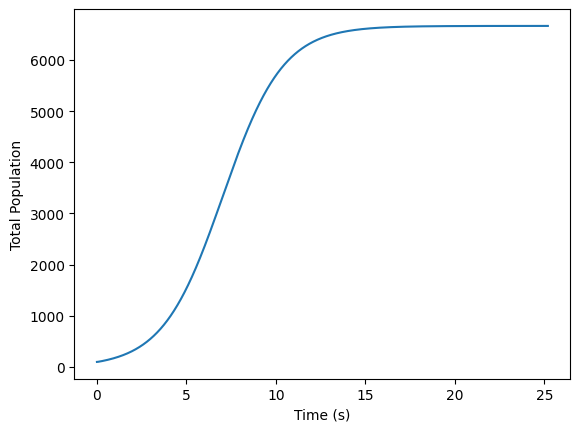

In [17]:
K, r, h = 1, 0.9, 0.3
population_frames, population_sizes = solve_heat(population_frames, terrain1, K, r, h)
plt.plot(np.linspace(0, times*dt, times), population_sizes)
plt.xlabel('Time (s)')
plt.ylabel('Total Population')
vmax = population_sizes[-1]/n**2
print('Final population', population_sizes[-1])

In [18]:
np.save(f'modelled data/hunting/terrain1', population_frames)

Make animation

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
def animate(i):
    ax.clear()
    a = ax.contourf(population_frames[10*i], 100, levels=np.linspace(0,vmax,50), cmap=plt.get_cmap('inferno'))
    ax.set_title(f't = {10*i*f*dt:.2f} sec')
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    return fig,

a = ax.contourf(population_frames[10*i], 100, levels=np.linspace(0,vmax,50), cmap=plt.get_cmap('inferno'))
fig.colorbar(a, ax=ax)
ani = animation.FuncAnimation(fig, animate, frames=359, interval=50, blit=True)
# ani.save('animations/5c/terrain1.gif',writer='pillow',fps=30)

In [20]:
HTML(ani.to_html5_video())

#### Terrain 2

Final population 6657.8190772686285


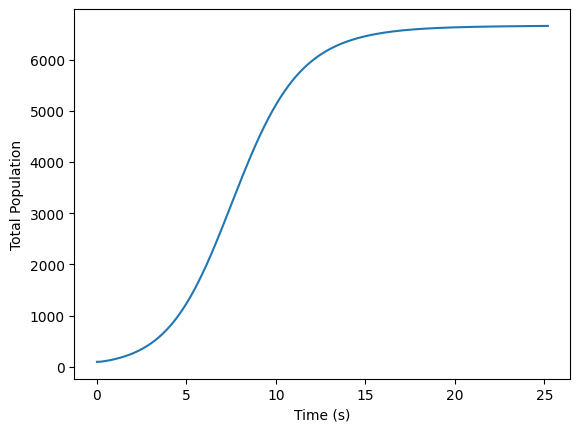

In [22]:
K, r, h = 1, 0.9, 0.3
population_frames, population_sizes = solve_heat(population_frames, terrain2, K, r, h)
plt.plot(np.linspace(0, times*dt, times), population_sizes)
plt.xlabel('Time (s)')
plt.ylabel('Total Population')
vmax = population_sizes[-1]/n**2
print('Final population', population_sizes[-1])

In [23]:
np.save(f'modelled data/hunting/terrain2', population_frames)

Make animation

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
def animate(i):
    ax.clear()
    a = ax.contourf(population_frames[10*i], 100, levels=np.linspace(0,vmax,50), cmap=plt.get_cmap('inferno'))
    ax.set_title(f't = {10*i*f*dt:.2f} sec')
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    return fig,

a = ax.contourf(population_frames[10*i], 100, levels=np.linspace(0,vmax,50), cmap=plt.get_cmap('inferno'))
fig.colorbar(a, ax=ax)
ani = animation.FuncAnimation(fig, animate, frames=359, interval=50, blit=True)
ani.save('animations/5c/terrain2.gif',writer='pillow',fps=30)

In [25]:
HTML(ani.to_html5_video())

#### Terrain 3

Final population 6666.51034503225


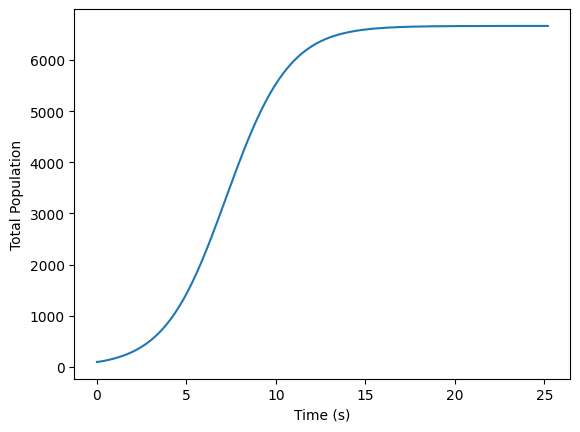

In [99]:
K, r, h = 1, 0.9, 0.3
population_frames, population_sizes = solve_heat(population_frames, terrain3, K, r, h)
plt.plot(np.linspace(0, times*dt, times), population_sizes)
plt.xlabel('Time (s)')
plt.ylabel('Total Population')
vmax = population_sizes[-1]/n**2
print('Final population', population_sizes[-1])

In [101]:
np.save(f'modelled data/hunting/terrain3', population_frames)

Make animation

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
def animate(i):
    ax.clear()
    a = ax.contourf(population_frames[10*i], 100, levels=np.linspace(0,vmax,50), cmap=plt.get_cmap('inferno'))
    ax.set_title(f't = {10*i*f*dt:.2f} sec')
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    return fig,

a = ax.contourf(population_frames[10*i], 100, levels=np.linspace(0,vmax,50), cmap=plt.get_cmap('inferno'))
fig.colorbar(a, ax=ax)
ani = animation.FuncAnimation(fig, animate, frames=359, interval=50, blit=True)
ani.save('animations/5c/terrain3.gif',writer='pillow',fps=30)

In [102]:
HTML(ani.to_html5_video())

#### Terrain 4

Final population 6630.3617956095695


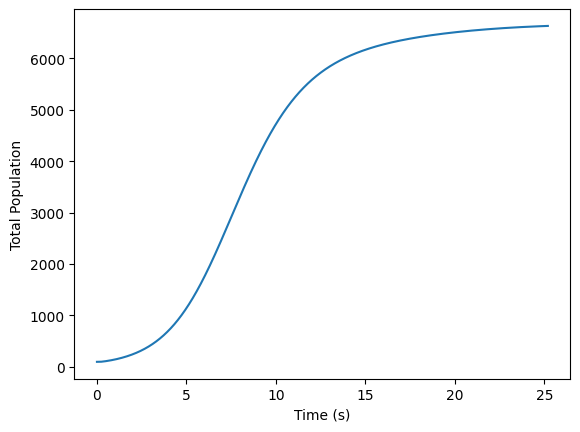

In [52]:
K, r, h = 1, 0.9, 0.3
population_frames, population_sizes = solve_heat(population_frames, terrain4, K, r, h)
plt.plot(np.linspace(0, times*dt, times), population_sizes)
plt.xlabel('Time (s)')
plt.ylabel('Total Population')
vmax = population_sizes[-1]/n**2
print('Final population', population_sizes[-1])

In [53]:
np.save(f'modelled data/hunting/terrain4', population_frames)

Make animation

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
def animate(i):
    ax.clear()
    a = ax.contourf(population_frames[10*i], 100, levels=np.linspace(0,vmax,50), cmap=plt.get_cmap('inferno'))
    ax.set_title(f't = {10*i*f*dt:.2f} sec')
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    return fig,

a = ax.contourf(population_frames[10*i], 100, levels=np.linspace(0,vmax,50), cmap=plt.get_cmap('inferno'))
fig.colorbar(a, ax=ax)
ani = animation.FuncAnimation(fig, animate, frames=359, interval=50, blit=True)
ani.save('animations/5c/terrain4.gif',writer='pillow',fps=30)

In [55]:
HTML(ani.to_html5_video())

# Final Plots

In [66]:
compare_sizes = {} 
my_cmap = plt.get_cmap('inferno')
loc = 'modelled data/hunting'

Terrain 1

In [123]:
name='terrain1'
modelled_frames = np.load(f'{loc}/{name}.npy')
compare_sizes[name] = np.array([np.average(modelled_frames[i]) for i in range(0, 3600, 2)])

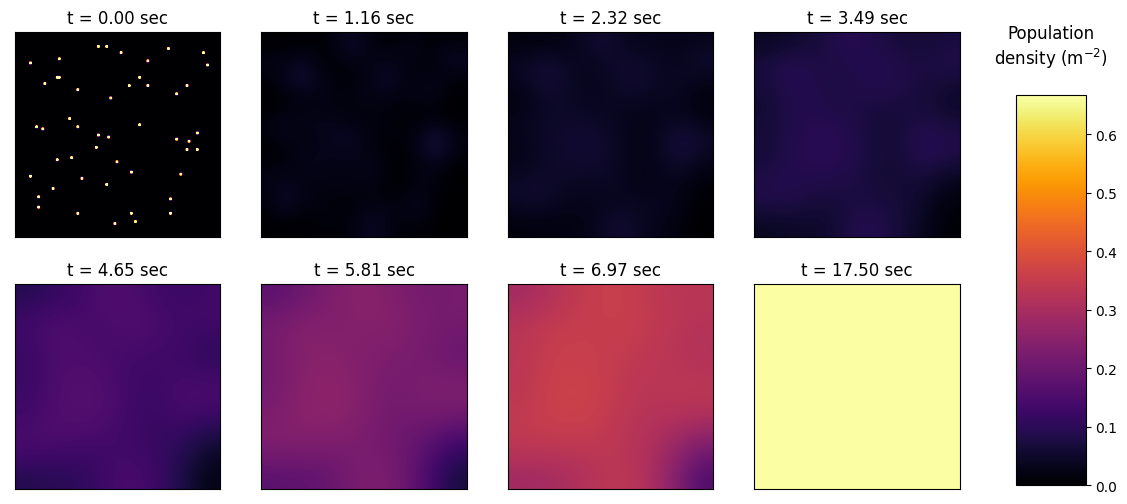

In [124]:
show_frame_id = [int(1500/9)*i for i in range(0, 8)]
fig, ax = plt.subplots(figsize=(14,6))
vmax = np.max(modelled_frames[-1])

for i in range(len(show_frame_id)):
    plt.subplot(240 + i + 1, anchor='C')
    im = plt.imshow(modelled_frames[show_frame_id[i]], cmap=my_cmap, vmin=0, vmax=vmax)
    plt.xticks([]), plt.yticks([])
    plt.title(f't = {f*dt*show_frame_id[i]:.2f} sec')

im = plt.imshow(modelled_frames[2500], cmap=my_cmap, vmin=0, vmax=vmax)
plt.title(f't = {f*dt*2500:.2f} sec')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.12, 0.05, 0.65])
fig.colorbar(im, cax=cbar_ax)
plt.title('Population\ndensity'+r' (m$^{-2})$'+'\n')
plt.savefig(f'plots/5c/{name}_spread.png', bbox_inches='tight')
plt.show()

Terrain 2

In [121]:
name='terrain2'
modelled_frames = np.load(f'{loc}/{name}.npy')
compare_sizes[name] = np.array([np.average(modelled_frames[i]) for i in range(0, 3600, 2)])

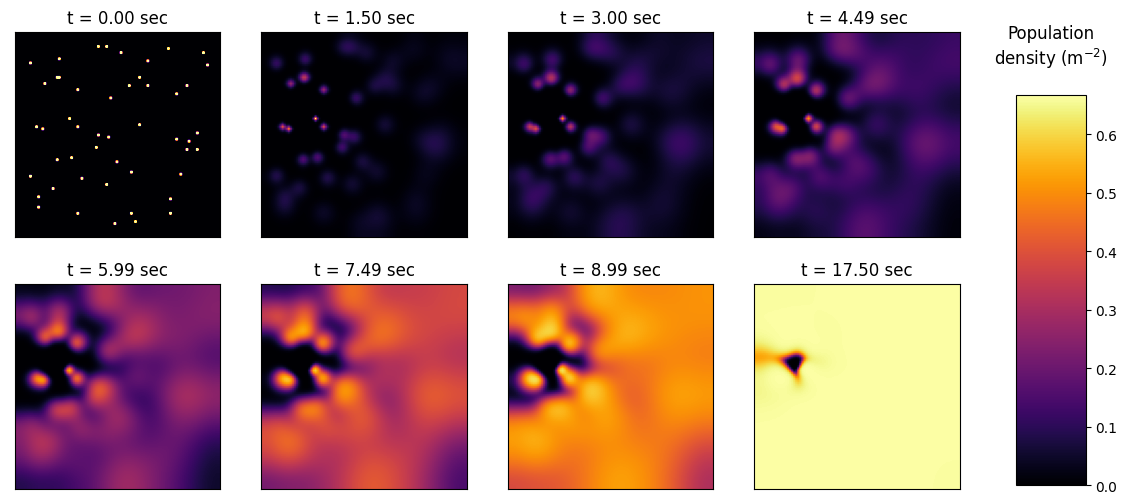

In [122]:
show_frame_id = [int(1500/7)*i for i in range(0, 8)]
fig, ax = plt.subplots(figsize=(14,6))
vmax = np.max(modelled_frames[-1])

for i in range(len(show_frame_id)):
    plt.subplot(240 + i + 1, anchor='C')
    im = plt.imshow(modelled_frames[show_frame_id[i]], cmap=my_cmap, vmin=0, vmax=vmax)
    plt.xticks([]), plt.yticks([])
    plt.title(f't = {f*dt*show_frame_id[i]:.2f} sec')

im = plt.imshow(modelled_frames[2500], cmap=my_cmap, vmin=0, vmax=vmax)
plt.title(f't = {f*dt*2500:.2f} sec')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.12, 0.05, 0.65])
fig.colorbar(im, cax=cbar_ax)
plt.title('Population\ndensity'+r' (m$^{-2})$'+'\n')
plt.savefig(f'plots/5c/{name}_spread.png', bbox_inches='tight')
plt.show()

Terrain 3

In [119]:
name='terrain3'
modelled_frames = np.load(f'{loc}/{name}.npy')
compare_sizes[name] = np.array([np.average(modelled_frames[i]) for i in range(0, 3600, 2)])

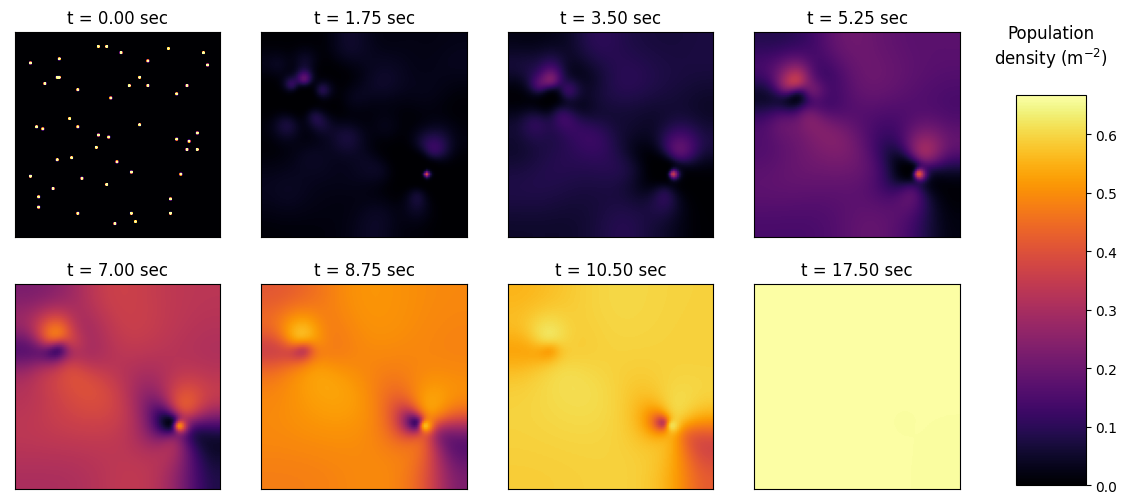

In [120]:
show_frame_id = [int(1500/6)*i for i in range(0, 8)]
fig, ax = plt.subplots(figsize=(14,6))
vmax = np.max(modelled_frames[-1])

for i in range(len(show_frame_id)):
    plt.subplot(240 + i + 1, anchor='C')
    im = plt.imshow(modelled_frames[show_frame_id[i]], cmap=my_cmap, vmin=0, vmax=vmax)
    plt.xticks([]), plt.yticks([])
    plt.title(f't = {f*dt*show_frame_id[i]:.2f} sec')

im = plt.imshow(modelled_frames[2500], cmap=my_cmap, vmin=0, vmax=vmax)
plt.title(f't = {f*dt*2500:.2f} sec')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.12, 0.05, 0.65])
fig.colorbar(im, cax=cbar_ax)
plt.title('Population\ndensity'+r' (m$^{-2})$'+'\n')
plt.savefig(f'plots/5c/{name}_spread.png', bbox_inches='tight')
plt.show()

Terrain 4

In [117]:
name='terrain4'
modelled_frames = np.load(f'{loc}/{name}.npy')
compare_sizes[name] = np.array([np.average(modelled_frames[i]) for i in range(0, 3600, 2)])

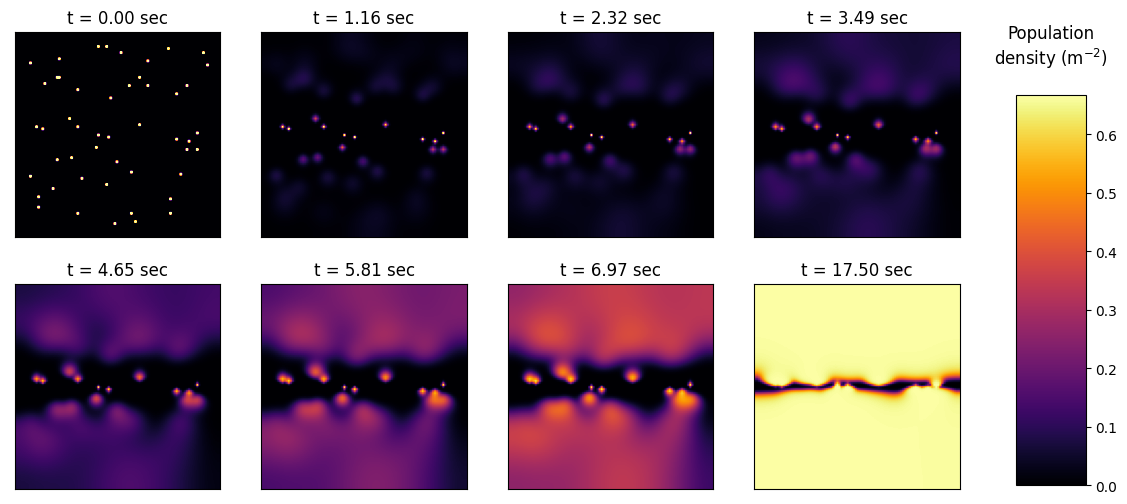

In [118]:
show_frame_id = [int(1500/9)*i for i in range(0, 8)]
fig, ax = plt.subplots(figsize=(14,6))
vmax = np.max(modelled_frames[-1])

for i in range(len(show_frame_id)):
    plt.subplot(240 + i + 1, anchor='C')
    im = plt.imshow(modelled_frames[show_frame_id[i]], cmap=my_cmap, vmin=0, vmax=vmax)
    plt.xticks([]), plt.yticks([])
    plt.title(f't = {f*dt*show_frame_id[i]:.2f} sec')

im = plt.imshow(modelled_frames[2500], cmap=my_cmap, vmin=0, vmax=vmax)
plt.title(f't = {f*dt*2500:.2f} sec')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.12, 0.05, 0.65])
fig.colorbar(im, cax=cbar_ax)
plt.title('Population\ndensity'+r' (m$^{-2})$'+'\n')
plt.savefig(f'plots/5c/{name}_spread.png', bbox_inches='tight', dpi=200)
plt.show()

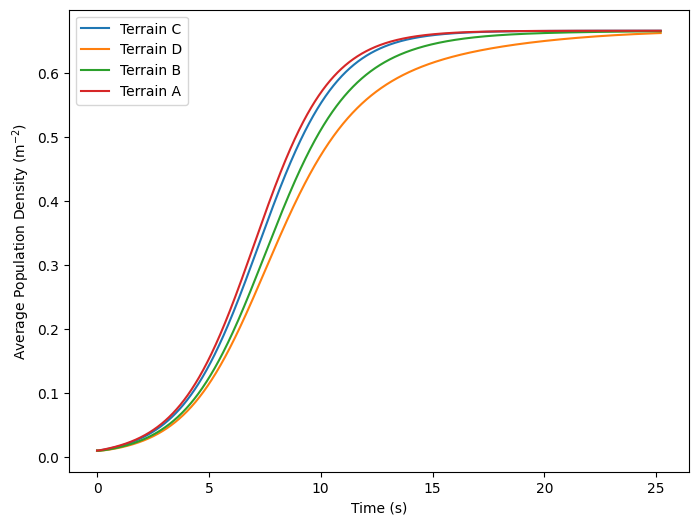

In [116]:
labels = {
    'terrain1': 'Terrain A',
    'terrain2': 'Terrain B',
    'terrain3': 'Terrain C',
    'terrain4': 'Terrain D',
}
plt.figure(figsize=(8,6))
for model in compare_sizes:
    plt.plot(np.linspace(0, times*dt, 1800), compare_sizes[model], label=labels[model])

plt.xlabel('Time (s)')
plt.ylabel(r'Average Population Density (m$^{-2}$)')
plt.legend()
plt.savefig(f'plots/5c/all_sizes.png', bbox_inches='tight', dpi=200)